In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

#from models.glm import GLM
#from models.tcn import TCN
#from models.sub_tcn import Sub_TCN
#from models.sub_cos_tcn import Sub_Cos_TCN
from models.sub_hist_tcn import Sub_Hist_TCN

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

part_C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")
part_C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_i.npy")
part_C_syn_e = torch.from_numpy(part_C_syn_e)
part_C_syn_i = torch.from_numpy(part_C_syn_i)

In [3]:
T_train = 990 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 1
sub_no = 4
two_nonlin = False
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

batch_length = 50000
batch_size = 10
iter_no = 9900*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_i = torch.zeros(sub_no, I_no).to(device)

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[0,i] = 1
    elif den == den_idx[1]:
        C_syn_e[1,i] = 1
    elif den == den_idx[2]:
        C_syn_e[2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[3,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[0,i] = 1
    elif den == den_idx[1]:
        C_syn_e[1,i] = 1
    elif den == den_idx[2]:
        C_syn_e[2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[3,i] = 1

# Train

In [6]:
#model = GLM(C_den, C_syn_e, C_syn_i, T_no, device)
model = Sub_Hist_TCN(C_syn_e, C_syn_i, T_no, H_no, two_nonlin, device)

#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For GLM
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # For TCN / Sub TCN
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For Cos TCN

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

6213


In [ ]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred = model(batch_E_neural[:,15000:35000,:], batch_I_neural[:,15000:35000,:])
    
    loss = torch.mean((V_pred - batch_V[:,15000:35000])**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    if i == 0:
        print(time.time() - s)
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(test_E_neural.unsqueeze(0)[:,15000:35000,:], test_I_neural.unsqueeze(0)[:,15000:35000,:])
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[15000:35000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[15000:35000]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-7-5e0273d6d11d>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


13.34977674484253
0 -0.045411 0.500069
49 0.218678 0.053653
99 0.235041 0.051499
149 0.235725 0.051422
199 0.23437 0.051537


torch.Size([35000])
torch.Size([50000])


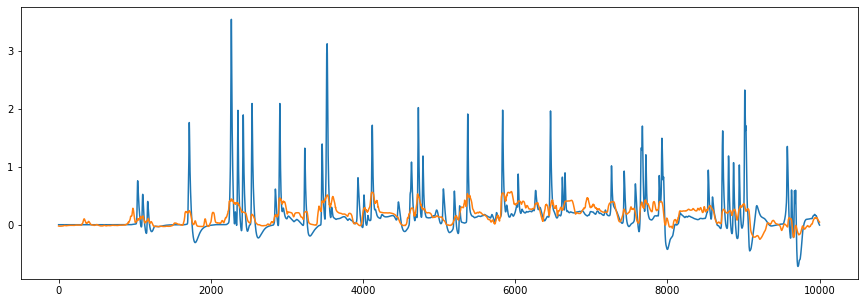

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000])

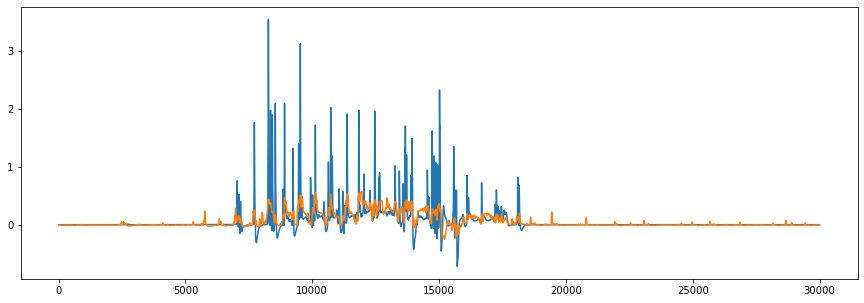

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000])
plt.plot(test_V_pred.cpu().detach().numpy())

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

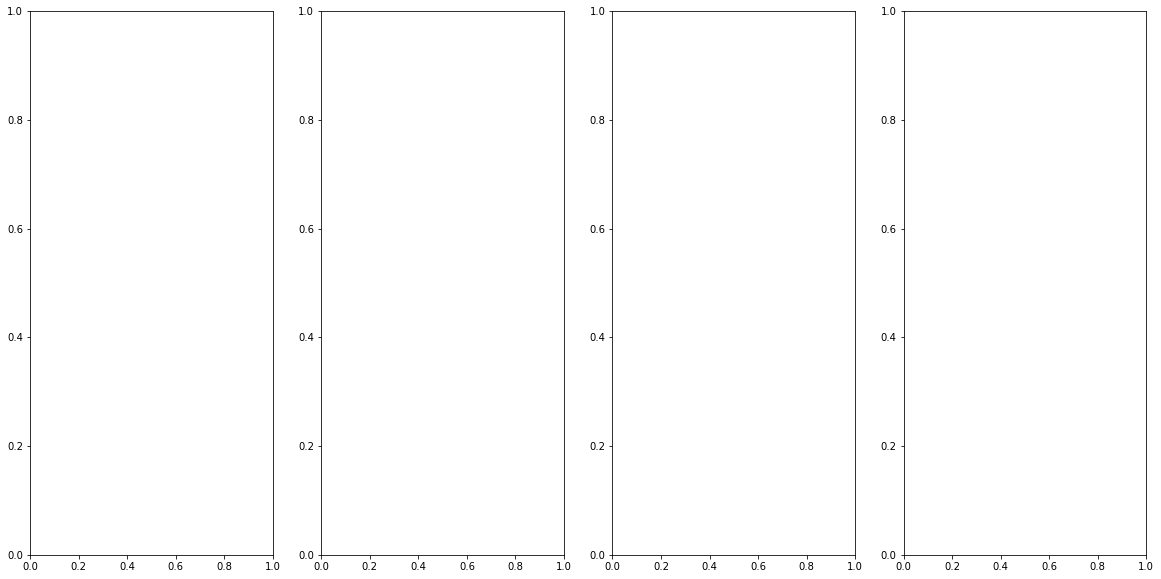

In [11]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.flip(np.abs(model.W_layer1[idx].cpu().detach().numpy())))
        #idx = np.random.randint(0,model.tcn[0].weight.shape[0])
        axs[i,j].plot(np.flip(model.W_layer1[idx].cpu().detach().numpy()), label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()